In [180]:
# Use svg graphics, display inline
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import glob
import re
import copy
import sys
import json

# Basic scientific computing imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, WeekdayLocator

# Basic preprocessing, regression, classification, validation
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MaxAbsScaler, StandardScaler, PolynomialFeatures
from sklearn.linear_model import RidgeCV, LogisticRegressionCV, LogisticRegression

# Hex colors for plotting
FB_BLUE = '#1877F2'
FB_HERITAGE_BLUE = '#3b5998'
FB_LIGHT_BLUE = '#8b9dc3'
FB_VERY_LIGHT_BLUE = '#dfe3ee'
SOFT_RED = '#C23F38'
SOFT_GREEN = '#56B000'
NEUTRAL_GREY = '#A9A9A9'

# display config
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.rcParams['figure.figsize'] = 10, 6
np.set_printoptions(suppress=True)

# ad hoc imports
import requests
import json
import os

print(sys.version)

3.7.7 (default, Mar 26 2020, 10:32:53) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


## Load the Data
---
url for data: https://data.seattle.gov/Public-Safety/Call-Data/33kz-ixgy/data

note that it's huge, ~770MB

In [2]:
df = pd.read_csv('./data/Call_Data.csv')

In [3]:
df.shape

(4615716, 11)

In [4]:
def format_columns(col_name):
    return col_name.lower().replace(' ', '_')

df.columns = [format_columns(col) for col in df.columns]
df.columns

Index(['cad_event_number', 'event_clearance_description', 'call_type',
       'priority', 'initial_call_type', 'final_call_type',
       'original_time_queued', 'arrived_time', 'precinct', 'sector', 'beat'],
      dtype='object')

## Cleaning and preprocessing
---
- Remove data before 2019 to save space
- Some rows are logged with a defaulta date 

In [5]:
# remove days before 2019 to save space
after_2019_inds = np.array([int(x.split('/')[2][:4]) >= 2019 for x in df.original_time_queued])
df = df[after_2019_inds]

# hacky date parsing to pare down the size
good_arrived_time_inds = np.array([not x.startswith('Jan 01 1900') for x in df.arrived_time])
df = df[good_arrived_time_inds]

print(f'{df.shape[0]} rows in resulting df')

df.head()

767900 rows in resulting df


,cad_event_number,event_clearance_description,call_type,priority,initial_call_type,final_call_type,original_time_queued,arrived_time,precinct,sector,beat
11,2019000311497,ASSISTANCE RENDERED,ONVIEW,7,DIRECTED PATROL ACTIVITY,--DIRECTED PATROL ACTIVITY,08/21/2019 18:14:07 PM,Aug 21 2019 18:14:07:000PM,SOUTH,OCEAN,O1
31,2021000113027,RESPONDING UNIT(S) CANCELLED BY RADIO,911,1,UNKNOWN - ANI/ALI - WRLS PHNS (INCL OPEN LINE),--ASSIST OTHER AGENCY - CITY AGENCY,05/09/2021 06:01:53 AM,May 09 2021 06:08:40:000AM,WEST,DAVID,D1
32,2019000170536,PROBLEM SOLVING PROJECT,ONVIEW,7,DIRECTED PATROL ACTIVITY,--DIRECTED PATROL ACTIVITY,05/12/2019 13:05:40 PM,May 12 2019 13:05:40:000PM,SOUTHWEST,FRANK,F1
35,2019000074028,ASSISTANCE RENDERED,911,1,DOWN - CHECK FOR PERSON DOWN,--MISCHIEF OR NUISANCE - GENERAL,02/28/2019 13:42:21 PM,Feb 28 2019 13:50:58:000PM,EAST,CHARLIE,C1
36,2020000296622,ASSISTANCE RENDERED,"TELEPHONE OTHER, NOT 911",2,TRESPASS,--ASSIST PUBLIC - OTHER (NON-SPECIFIED),10/17/2020 23:52:44 PM,Oct 17 2020 23:59:44:000PM,WEST,KING,K1


In [7]:
columns_to_lower = (
    'event_clearance_description', 'call_type', 'final_call_type', 
    'initial_call_type', 'precint', 'sector'
)
for column in columns_to_lower:
    df[column] = df[column].str.lower()

df['arrived_date'] = pd.to_datetime( [' '.join(x.split(' ')[:3]) for x in df.arrived_time] )
df['arrived_hour'] = [int(x.split(' ')[-1][:2]) for x in df.arrived_time]

df['arrived_ts'] = pd.to_datetime([x[:-6] for x in df.arrived_time])
df['enqueued_ts'] = pd.to_datetime([x.replace('PM', '').replace('AM', '') for x in df.original_time_queued])

df['response_time_mins'] = [x.seconds / 60 for x in df.arrived_ts - df.enqueued_ts]

In [8]:
df['ds_index'] = copy.copy(df.arrived_date)
df.sort_values('ds_index', inplace=True)
df.set_index('ds_index', inplace=True)

In [12]:
df.head(3)

,cad_event_number,event_clearance_description,call_type,priority,initial_call_type,final_call_type,original_time_queued,arrived_time,precinct,sector,beat,arrived_date,arrived_hour,arrived_ts,enqueued_ts,response_time_mins
ds_index,,,,,,,,,,,,,,,,
2019-01-01,2019000000222,unable to locate incident or complainant,911,2,dist - dv - no aslt,--disturbance - other,01/01/2019 02:21:25 AM,Jan 01 2019 04:54:10:000AM,west,king,K3,2019-01-01,4,2019-01-01 04:54:10,2019-01-01 02:21:25,152.750
2019-01-01,2019000000053,report written (no arrest),"telephone other, not 911",3,theft (does not include shoplift or svcs),--theft - car prowl,01/01/2019 00:34:31 AM,Jan 01 2019 01:08:05:000AM,west,mary,M3,2019-01-01,1,2019-01-01 01:08:05,2019-01-01 00:34:31,33.567
2019-01-01,2019000000512,assistance rendered,911,1,sfd - assist on fire or medic response,--assist other agency - city agency,01/01/2019 10:40:39 AM,Jan 01 2019 10:52:02:000AM,west,queen,Q1,2019-01-01,10,2019-01-01 10:52:02,2019-01-01 10:40:39,11.383


Make sure everything makes sense

In [13]:
df.call_type.value_counts()[:10] / df.call_type.value_counts().sum()

onview                          0.403
911                             0.353
telephone other, not 911        0.211
alarm call (not police alarm)   0.033
text message                    0.000
proactive (officer initiated)   0.000
scheduled event (recurring)     0.000
in person complaint             0.000
police (varda) alarm            0.000
history call (retro)            0.000
Name: call_type, dtype: float64

What are the text message calls lol

In [14]:
df[df.call_type == 'text message'].sample(3)

,cad_event_number,event_clearance_description,call_type,priority,initial_call_type,final_call_type,original_time_queued,arrived_time,precinct,sector,beat,arrived_date,arrived_hour,arrived_ts,enqueued_ts,response_time_mins
ds_index,,,,,,,,,,,,,,,,
2020-05-27,2020000173095,report written (no arrest),text message,2,"suspicious person, vehicle or incident",--crisis complaint - general,05/27/2020 00:27:24 AM,May 27 2020 00:31:55:000AM,west,david,D1,2020-05-27,0,2020-05-27 00:31:55,2020-05-27 00:27:24,4.517
2019-04-21,2019000141033,assistance rendered,text message,2,service - welfare check,--assist public - other (non-specified),04/21/2019 05:54:06 AM,Apr 21 2019 06:57:56:000AM,south,robert,R1,2019-04-21,6,2019-04-21 06:57:56,2019-04-21 05:54:06,63.833
2019-09-05,2019000332537,assistance rendered,text message,2,"disturbance, miscellaneous/other",--disturbance - other,09/05/2019 19:47:32 PM,Sep 05 2019 20:22:13:000PM,southwest,william,W2,2019-09-05,20,2019-09-05 20:22:13,2019-09-05 19:47:32,34.683


To Do:
  - Identify fast and slow crimes
    - reactive
    - proactive
  - Lay out the mix shift in proactive and reactive crimes
    - Did the mix change or did times actually get longer
  - Determine the rate that certain crimes are ended with an oral warning
  
---

# Identify fast and slow crimes

In [15]:
df.groupby('call_type').response_time_mins.agg([('avg_response_time', np.mean), ('total_calls', len)])

,avg_response_time,total_calls
call_type,,
911,34.856,271397.000
alarm call (not police alarm),65.907,25260.000
history call (retro),5.000,1.000
in person complaint,23.142,8.000
onview,0.060,309103.000
police (varda) alarm,42.867,2.000
proactive (officer initiated),47.859,44.000
scheduled event (recurring),42.254,15.000
"telephone other, not 911",66.917,161745.000


In [91]:
df['is_onview'] = [call_type == 'onview' for call_type in df.call_type]

Plot the trend for a few call types over time

In [54]:
top_call_types = ['911', 'alarm call (not police alarm)', 'onview', 'telephone other, not 911']

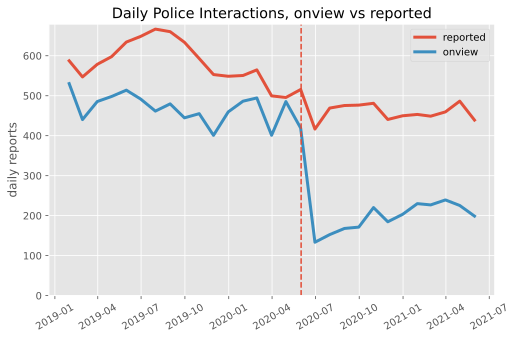

In [152]:
df_call_type_cnts = df.groupby(['is_onview', 'arrived_date']).cad_event_number.count()

with plt.style.context('ggplot'):
    plt.rcParams['figure.figsize'] = 8, 5
    for is_onview in df.is_onview.unique():
        data = df_call_type_cnts[is_onview].resample('M').mean()
        plt.plot(data, alpha=.95, linewidth=3, label='onview' if is_onview else 'reported')
        plt.ylabel('daily reports')
        plt.xticks(rotation=30)
        plt.ylim([0, None])
    
    plt.axvline(pd.to_datetime('2020-06-01'), linestyle='--')
    plt.legend()
    plt.title('Daily Police Interactions, onview vs reported')
    plt.show()

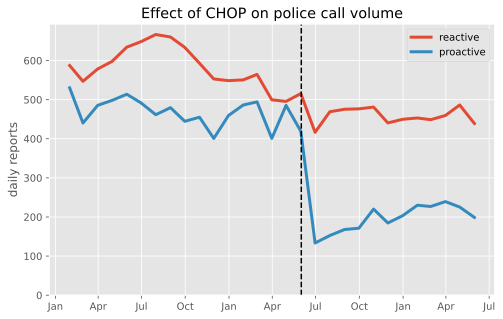

In [196]:

with plt.style.context('ggplot'):
    # Create figure and plot space
    fig, ax = plt.subplots(figsize=(8, 5))

    # Add x-axis and y-axis
    data_proactive = df_call_type_cnts[True].resample('M').mean()
    data_reactive = df_call_type_cnts[False].resample('M').mean()


    ax.plot(data_reactive, label='reactive', linewidth=3)
    ax.plot(data_proactive, label='proactive', linewidth=3)
    
    ax.axvline(pd.to_datetime('2020-06-01'), color='black', linestyle='--')
    
    ax.set(
        ylabel="daily reports",
        title="Effect of CHOP on police call volume",
        ylim=[0, None]
    )
#     ax.tick_params(axis='x', Labelrotation=30)
    
    # Define the date format
    date_form = DateFormatter("%b")
    ax.xaxis.set_major_formatter(date_form)

    # Ensure a major tick for each week using (interval=1) 
#     ax.xaxis.set_major_locator(WeekdayLocator(interval=1))

    
    
    ax.legend()
    fig.savefig('/Users/kyledrogo/Desktop/chop_crime_drop.png', format='png', dpi=400)
    plt.show()

In [ ]:
# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Precipitation (inches)",
       title="Daily Total Precipitation\nJune - Aug 2005 for Boulder Creek",
       xlim=["2005-06-01", "2005-08-31"])

# Define the date format
date_form = DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(date_form)

# Ensure a major tick for each week using (interval=1) 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

plt.show()

Export this data as a JSON file to plot in d3.js

In [143]:
df_call_type_cnts.reset_index()\
    .set_index('arrived_date')\
    .resample('Q')\
    .mean()\
    .groupby(['is_onview', 'arrived_date'])\
    .cad_event_number\
    .mean()

is_onview  arrived_date
0.494      2021-06-30     347.778
0.500      2019-03-31     529.278
           2019-06-30     564.060
           2019-09-30     557.875
           2019-12-31     501.924
           2020-03-31     498.720
           2020-06-30     411.527
           2020-09-30     318.723
           2020-12-31     330.065
           2021-03-31     343.089
Name: cad_event_number, dtype: float64

In [125]:
data = [{'is_onview': 1 if ind[0] else 0, 'date': str(ind[1]).split(' ')[0], 'count': cnt} for ind, cnt in df_call_type_cnts.iteritems()]
data[:3]

[{'is_onview': 0, 'date': '2019-01-01', 'count': 599},
 {'is_onview': 0, 'date': '2019-01-02', 'count': 579},
 {'is_onview': 0, 'date': '2019-01-03', 'count': 663}]

In [127]:
with open('./chart_for_post/data/police_calls.json', 'w') as f:
    json.dump(data, f)

Break out into top calls for onview. See if there was a mix shift or a certain kind declined

In [61]:
df[df.call_type == 'onview'].final_call_type.value_counts()[:10]

--premise checks - crime prevention         0.192
--traffic - moving violation                0.171
--directed patrol activity                  0.110
-off duty employment                        0.052
--assist public - other (non-specified)     0.032
--suspicious circum. - suspicious person    0.028
--suspicious circum. - suspicious vehicle   0.021
--mischief or nuisance - general            0.021
--prowler - trespass                        0.019
--premise checks - business check           0.018
Name: final_call_type, dtype: float64

In [63]:
df_final_call_type_cnts

final_call_type                                 arrived_date
--alarm-comm (inc bank, atm, schools, bsn)      2019-01-02      1
                                                2019-01-10      1
                                                2019-01-14      1
                                                2019-01-15      1
                                                2019-01-16      2
                                                               ..
weapn-ip/jo-gun,deadly wpn (no thrt/aslt/dist)  2019-11-25      1
                                                2020-02-07      1
                                                2020-06-02      1
                                                2020-08-13      2
                                                2020-08-20      1
Name: cad_event_number, Length: 51124, dtype: int64

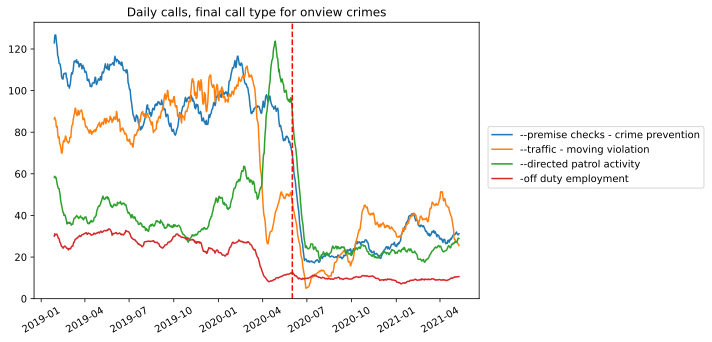

In [68]:
df_final_call_type_cnts = df[df.call_type == 'onview'].groupby(['final_call_type', 'arrived_date']).cad_event_number.count()
top_final_call_types = df[df.call_type == 'onview'].final_call_type.value_counts()[:4].keys().tolist()

with plt.style.context('default'):
    plt.rcParams['figure.figsize'] = 8, 5
    for final_call_type in top_final_call_types:
        data = df_final_call_type_cnts[final_call_type].rolling(28).mean()
        plt.plot(data, label=final_call_type)
        plt.xticks(rotation=30)
    
    plt.axvline(pd.to_datetime('2020-06-01'), color='red', linestyle='--')
    plt.ylim([0, None])
    plt.legend(loc=(1.02, .4))
    plt.title('Daily calls, final call type for onview crimes')
    plt.show()

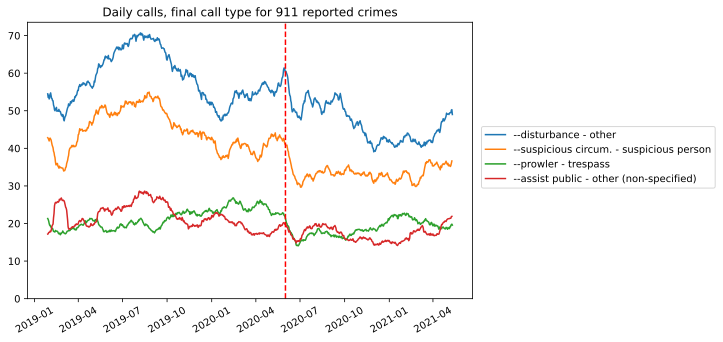

In [70]:
df_final_call_type_cnts = df[df.call_type == '911'].groupby(['final_call_type', 'arrived_date']).cad_event_number.count()
top_final_call_types = df[df.call_type == '911'].final_call_type.value_counts()[:4].keys().tolist()

with plt.style.context('default'):
    plt.rcParams['figure.figsize'] = 8, 5
    for final_call_type in top_final_call_types:
        data = df_final_call_type_cnts[final_call_type].rolling(28).mean()
        plt.plot(data, label=final_call_type)
        plt.xticks(rotation=30)
    
    plt.axvline(pd.to_datetime('2020-06-01'), color='red', linestyle='--')
    plt.ylim([0, None])
    plt.legend(loc=(1.02, .4))
    plt.title('Daily calls, final call type for 911 reported crimes')
    plt.show()

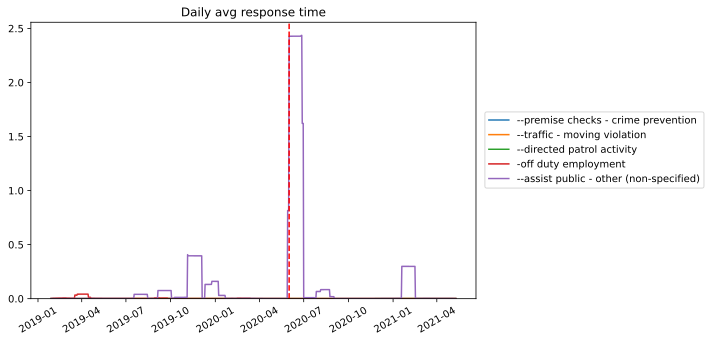

In [75]:
df_final_call_type_rt = df[df.call_type == 'onview'].groupby(['final_call_type', 'arrived_date']).response_time_mins.mean()
top_final_call_types = df[df.call_type == 'onview'].final_call_type.value_counts()[:5].keys().tolist()

with plt.style.context('default'):
    plt.rcParams['figure.figsize'] = 8, 5
    for final_call_type in top_final_call_types:
        data = df_final_call_type_rt[final_call_type].rolling(28).mean()
        plt.plot(data, label=final_call_type)
        plt.xticks(rotation=30)
    
    plt.axvline(pd.to_datetime('2020-06-01'), color='red', linestyle='--')
    plt.ylim([0, None])
    plt.legend(loc=(1.02, .4))
    plt.title('Daily avg response time')
    plt.show()

Check the response times for some notable crimes

In [84]:
bad_crimes = [
    'carjacking - ip/jo - robbery',
    '--prowler - trespass',
    '--rape - unknown suspect (stranger)',
    '--robbery - armed',
    '--robbery - strong arm',
    '--narcotics - drug traffic loitering',
    'carjacking - ip/jo - robbery'
]

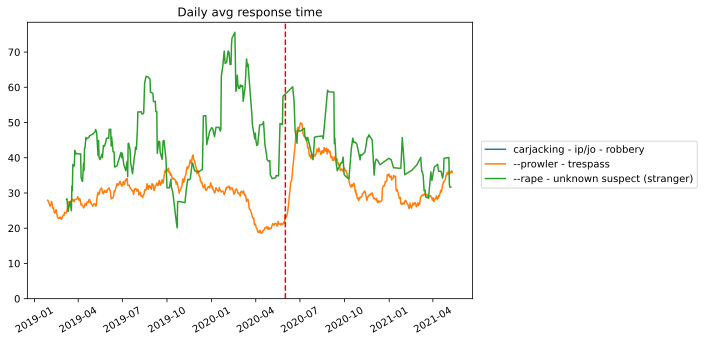

In [87]:
df_final_call_type_rt = df.groupby(['final_call_type', 'arrived_date']).response_time_mins.mean()
top_final_call_types = df.final_call_type.value_counts()[:5].keys().tolist()

with plt.style.context('default'):
    plt.rcParams['figure.figsize'] = 8, 5
    for final_call_type in bad_crimes[:3]:
        data = df_final_call_type_rt[final_call_type].rolling(28).mean()
        plt.plot(data, label=final_call_type)
        plt.xticks(rotation=30)
    
    plt.axvline(pd.to_datetime('2020-06-01'), color='red', linestyle='--')
    plt.ylim([0, None])
    plt.legend(loc=(1.02, .4))
    plt.title('Daily avg response time')
    plt.show()

In [83]:
# sorted(df.groupby('final_call_type').priority.max().items(), key=lambda x: -x[1])